In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn

import warnings
warnings.simplefilter("ignore")

In [12]:
entropy = pd.read_csv("entropy.csv").drop("Unnamed: 0", axis=1)
accuracy = pd.read_csv("RFCs_accuracy.csv")
cm = pd.read_csv("classification_metric.csv").drop("Unnamed: 0", axis=1)
dm = pd.read_csv("diameter_metric.csv").drop("Unnamed: 0", axis=1)

entropy["cond_entropy"] = entropy["cond_entropy"]/max(entropy["cond_entropy"])
cm["cm"] = cm["cm"]/max(cm["cm"])

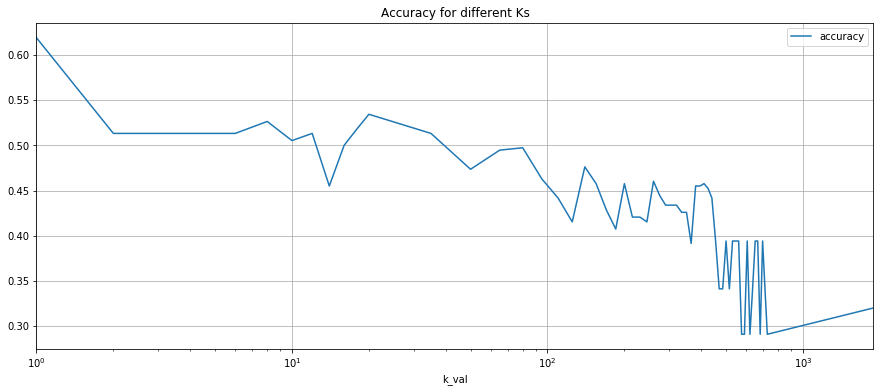

In [13]:
accuracy.plot("k_val", "accuracy", figsize=(15,6), grid=True, logx=True, title="Accuracy for different Ks")

In [14]:
data = pd.DataFrame()
data[["k_val","accuracy"]] = accuracy[["k_val", "accuracy"]]
data = data.merge(entropy)
data = data.merge(cm)
data = data.merge(dm)

In [15]:
data.head()

,k_val,accuracy,cond_entropy,cm,dm
0,1,0.619048,0.000000,0.067568,1.000000
1,2,0.513228,0.441155,0.414944,0.888889
2,4,0.513228,0.501257,0.506359,0.833333
3,6,0.513228,0.533030,0.566773,0.777778
4,8,0.526455,0.561195,0.604928,0.777778


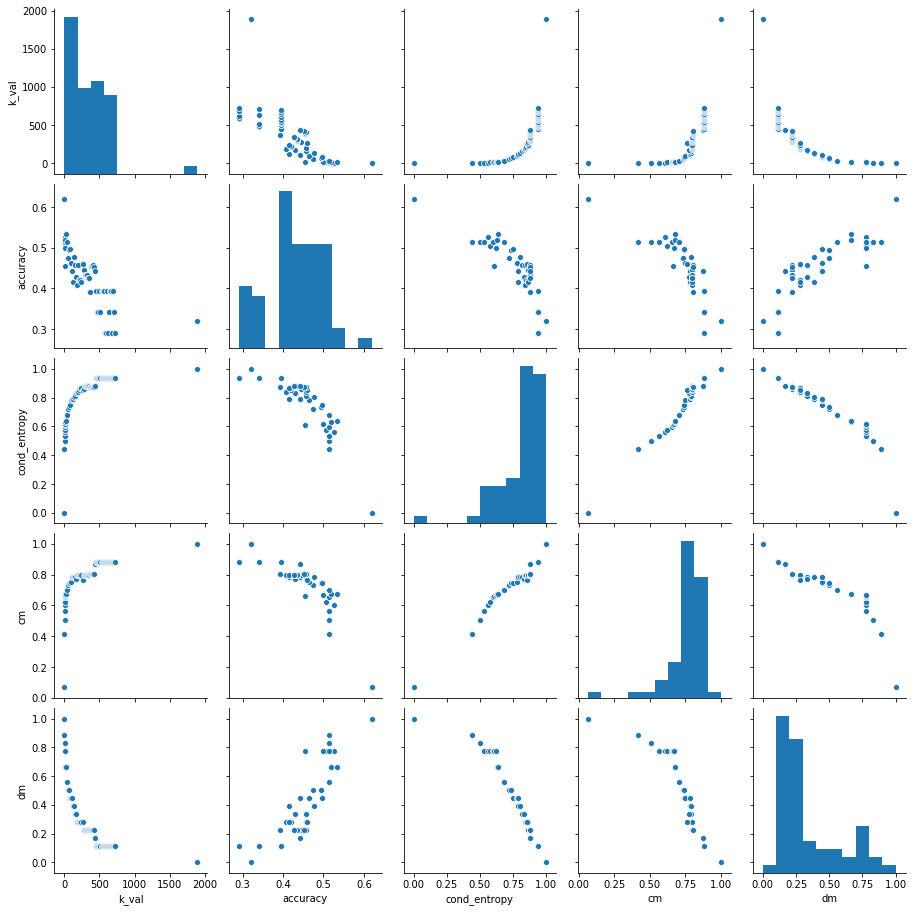

In [16]:
sbn.pairplot(data)

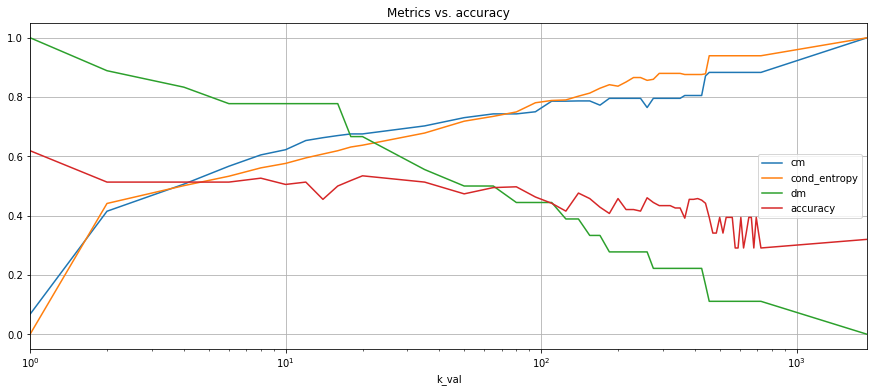

In [17]:
data.plot("k_val", ["cm", "cond_entropy", "dm", "accuracy"], figsize=(15,6), grid=True, logx=True, title="Metrics vs. accuracy")

# Linear Regression



In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressors):
    X = data[regressors]
    y = data["accuracy"]

    reg = LinearRegression()
    reg.fit(X, y)
    print(f"R2 Score: {reg.score(X,y)}")
    print(f"Coeffs: {reg.coef_}")
    print(f"Intercept: {reg.intercept_}")
    return reg, reg.coef_, reg.intercept_

def mse(reg, attributes):
    attrs = np.array(data[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = data["accuracy"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

### Conditional Entropy

R2 Score: 0.6565015324236582
Coeffs: [-0.33300766]
Intercept: 0.697929451593601
MSE: 0.0016933746018400753


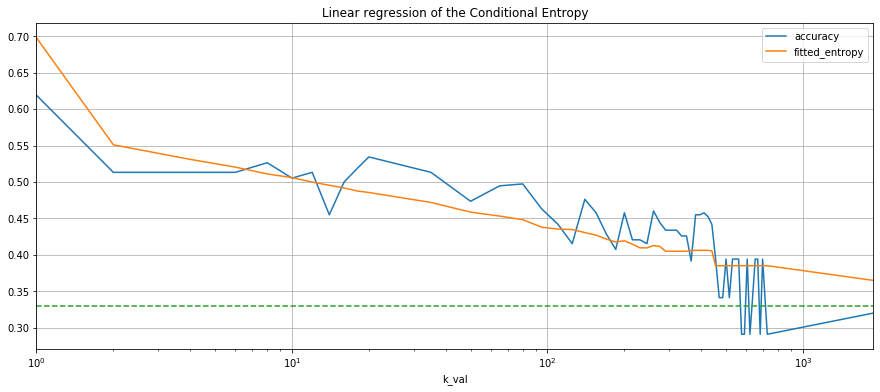

In [19]:
reg, coeff, intercept = regress(["cond_entropy"])
entropy_reg = data[["k_val", "accuracy", "cond_entropy"]]
entropy_reg["fitted_entropy"] = coeff*entropy_reg["cond_entropy"] + intercept
entropy_reg.plot("k_val", ["accuracy", "fitted_entropy"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of the Conditional Entropy")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['cond_entropy'])
mses.append((True, False, False, coeff[0], None, None, err))
print(f"MSE: {err}")


### Classification Metric

R2 Score: 0.6359660190378694
Coeffs: [-0.39980458]
Intercept: 0.7387851365913569
MSE: 0.001794610328009692


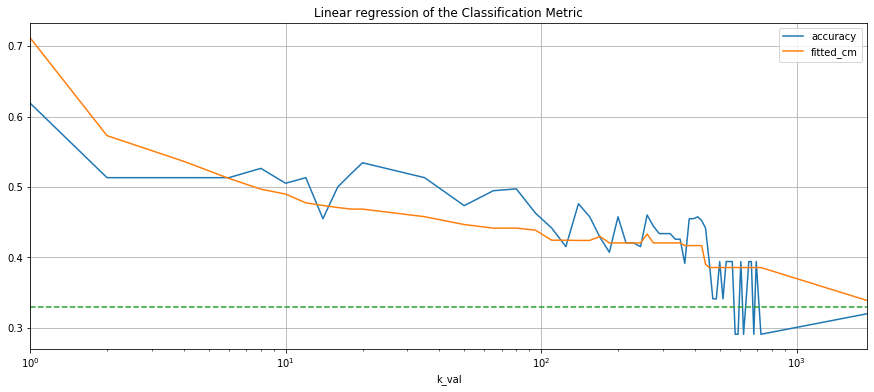

In [20]:
reg, coeff, intercept = regress(["cm"])
cm_reg = data[["k_val", "accuracy", "cm"]]
cm_reg["fitted_cm"] = coeff*cm_reg["cm"] + intercept
cm_reg.plot("k_val", ["accuracy", "fitted_cm"], figsize=(15,6), grid=True,
            logx=True, title="Linear regression of the Classification Metric")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['cm'])
mses.append((False,True,False,None,coeff[0], None, err))
print(f"MSE: {err}")

### Diameter Metric

R2 Score: 0.6888971542635722
Coeffs: [0.22995275]
Intercept: 0.3519346835929751
MSE: 0.0015336710560816533


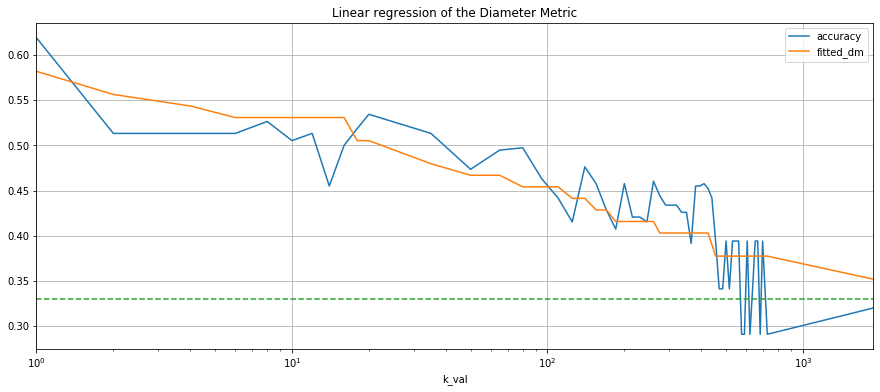

In [21]:
reg, coeff, intercept = regress(["dm"])
cm_reg = data[["k_val", "accuracy", "dm"]]
cm_reg["fitted_dm"] = coeff*cm_reg["dm"] + intercept
cm_reg.plot("k_val", ["accuracy", "fitted_dm"], figsize=(15,6), grid=True,
            logx=True, title="Linear regression of the Diameter Metric")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['dm'])
mses.append((False, False,True,None, None, coeff[0], err))
print(f"MSE: {err}")

### Entropy & CM

**Entropy more relevant this time...**

R2 Score: 0.656822682849812
Coeffs: [-0.29690842 -0.04494163]
Intercept: 0.7036042867313796
MSE: 0.0016917913983432557


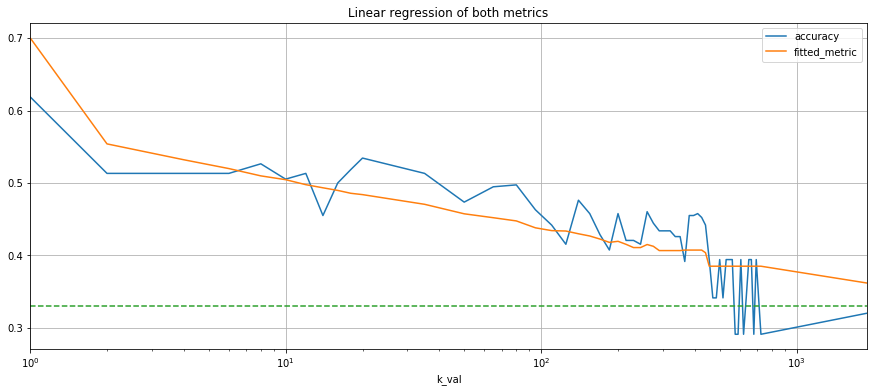

In [22]:
reg, coeffs, intercept = regress(["cond_entropy", "cm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "cm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["cm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of both metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")


err = mse(reg, ['cond_entropy','cm'])
mses.append((True, True, False, coeffs[0], coeffs[1], None, err))
print(f"MSE: {err}")

### Entropy & DM

R2 Score: 0.6955269617773574
Coeffs: [-0.1012254   0.16555334]
Intercept: 0.45529517905396005
MSE: 0.0015009875109754814


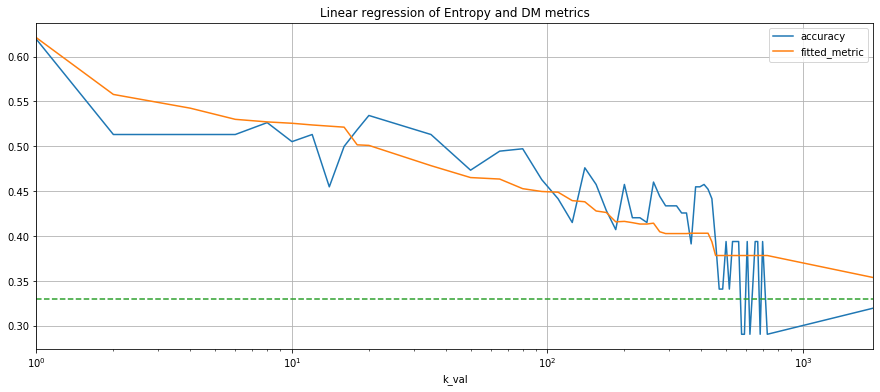

In [23]:
reg, coeffs, intercept = regress(["cond_entropy", "dm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "dm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["dm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of Entropy and DM metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['cond_entropy','dm'])
mses.append((True, False, True, coeffs[0], None, coeffs[1], err))
print(f"MSE: {err}")

### CM & DM

R2 Score: 0.7039417514419642
Coeffs: [ 0.16182654 -0.13776297]
Intercept: 0.48157250630753823
MSE: 0.0014595043823944062


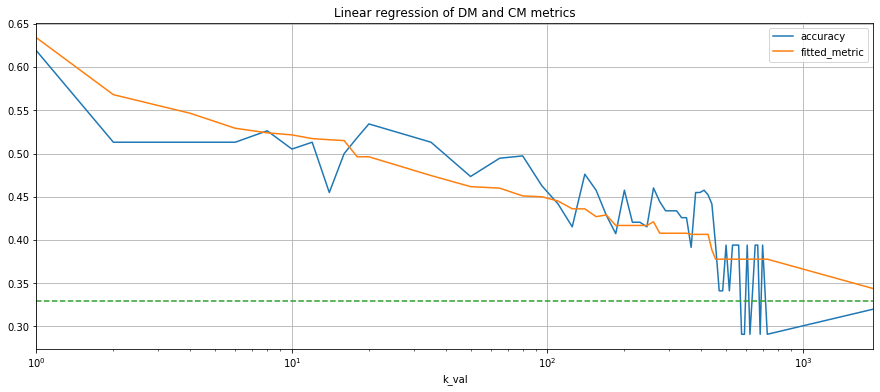

In [24]:
reg, coeffs, intercept = regress(["dm", "cm"])
m_reg = data[["k_val", "accuracy", "dm", "cm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["dm"] + coeffs[1]*m_reg["cm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of DM and CM metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")

err = mse(reg, ['dm','cm'])
mses.append((False, True, True, None, coeffs[0], coeffs[1], err))
print(f"MSE: {err}")

### All 3 Metrics

R2 Score: 0.7099699641808431
Coeffs: [ 0.24160272 -0.33786207  0.21658121]
Intercept: 0.42317121063804475
MSE: 0.0014297865719525371


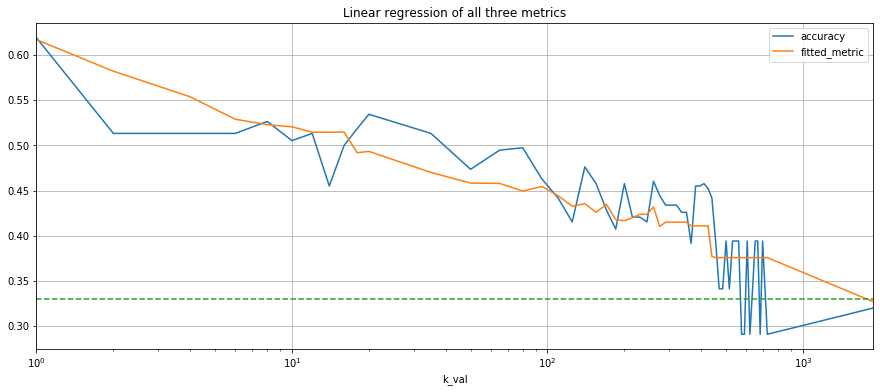

In [25]:
reg, coeffs, intercept = regress(["cond_entropy", "cm", "dm"])
m_reg = data[["k_val", "accuracy", "cond_entropy", "cm", "dm"]]
m_reg["fitted_metric"] = coeffs[0]*m_reg["cond_entropy"] + coeffs[1]*m_reg["cm"] + coeffs[2]*m_reg["dm"] + intercept
m_reg.plot("k_val", ["accuracy", "fitted_metric"], figsize=(15,6), grid=True, 
                 logx=True, title="Linear regression of all three metrics")
plt.plot([1, 1000, 10000], [0.33,0.33,0.33], linestyle="--")


err = mse(reg, ['cond_entropy','cm','dm'])
mses.append((True, True, True, coeffs[0], coeffs[1], coeffs[2], err))
print(f"MSE: {err}")

In [26]:
df = pd.DataFrame(mses, columns=["Entropy", "CM", "DM", "Entropy_coeff", "CM_coeff", "DM_coeff", "MSE"])
df

,Entropy,CM,DM,Entropy_coeff,CM_coeff,DM_coeff,MSE
0,True,False,False,-0.333008,NaN,NaN,0.001693
1,False,True,False,NaN,-0.399805,NaN,0.001795
2,False,False,True,NaN,NaN,0.229953,0.001534
3,True,True,False,-0.296908,-0.044942,NaN,0.001692
4,True,False,True,-0.101225,NaN,0.165553,0.001501
5,False,True,True,NaN,0.161827,-0.137763,0.001460
6,True,True,True,0.241603,-0.337862,0.216581,0.001430
